In [2]:
import tensorflow as tf
tf.__version__

'2.9.0'

In [3]:
# Check if we're using a GPU
!nvidia-smi

Sun Apr  7 02:00:28 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.34                 Driver Version: 537.34       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   52C    P0              29W / 129W |      0MiB /  6144MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Importing from helper functions

In [4]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

### Collecting data

In [5]:
# Check out how many images and directories are there in our dataset
walk_through_dir("D:\DeepLearningModels\IoT_Plant_Care\dataset")

There are 4 directories and 0 images in 'D:\DeepLearningModels\IoT_Plant_Care\dataset'.
There are 1 directories and 0 images in 'D:\DeepLearningModels\IoT_Plant_Care\dataset\New Plant Diseases Dataset(Augmented)'.
There are 0 directories and 0 images in 'D:\DeepLearningModels\IoT_Plant_Care\dataset\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)'.
There are 1 directories and 0 images in 'D:\DeepLearningModels\IoT_Plant_Care\dataset\test'.
There are 0 directories and 33 images in 'D:\DeepLearningModels\IoT_Plant_Care\dataset\test\test'.
There are 38 directories and 0 images in 'D:\DeepLearningModels\IoT_Plant_Care\dataset\train'.
There are 0 directories and 2016 images in 'D:\DeepLearningModels\IoT_Plant_Care\dataset\train\Apple___Apple_scab'.
There are 0 directories and 1987 images in 'D:\DeepLearningModels\IoT_Plant_Care\dataset\train\Apple___Black_rot'.
There are 0 directories and 1760 images in 'D:\DeepLearningModels\IoT_Plant_Care\dataset\train\Apple___C

Creating train, test and validation dir paths

In [6]:
# Create training and test directory paths
train_dir = "D:/DeepLearningModels/IoT_Plant_Care/dataset/train"
valid_dir = "D:/DeepLearningModels/IoT_Plant_Care/dataset/valid"
test_dir = "D:/DeepLearningModels/IoT_Plant_Care/dataset/test"

In [7]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)

valid_data = tf.keras.preprocessing.image_dataset_from_directory(directory=valid_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)

Found 70295 files belonging to 38 classes.
Found 17572 files belonging to 38 classes.


In [8]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)


test_data = tf.keras.preprocessing.image_dataset_from_directory(valid_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis

Found 17572 files belonging to 38 classes.


In [9]:
train_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 38), dtype=tf.float32, name=None))>

### Training model

In [10]:
# Create checkpoint callback
checkpoint_path = "plant_38_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [11]:
# Create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

In [12]:
# Setup data augmentation
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.1)
    #preprocessing.Rescaling(1/255.) # Rescale inputs not required in efficientnet
], name = "data_augmentation")

In [19]:
# Setup the base model and freeze it's layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name = "input_layer")
x = data_augmentation(inputs)   # Augment images(this only happens during training phase)
x = base_model(x, training=False)   # Puts the base model in inference mode so weights which need to stay frozen stay frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data.class_names), activation="softmax", name = "output_layer")(x)

model = tf.keras.Model(inputs, outputs)

In [20]:
# Get a summary of model we have created
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 38)                48678     
                                                                 
Total params: 4,098,249
Trainable params: 48,678
Non-traina

In [21]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [22]:
# Fit
history_0 = model.fit(train_data,
                    epochs=2,
                    validation_data=test_data,
                    validation_steps=int(0.15*len(test_data)), # validate on 15% of test data during training
                    )

Epoch 1/2


2197/2197 [==============================] - 158s 70ms/step - loss: 0.4026 - accuracy: 0.9164 - val_loss: 0.1124 - val_accuracy: 0.9794
Epoch 2/2
2197/2197 [==============================] - 154s 70ms/step - loss: 0.1235 - accuracy: 0.9678 - val_loss: 0.0731 - val_accuracy: 0.9855


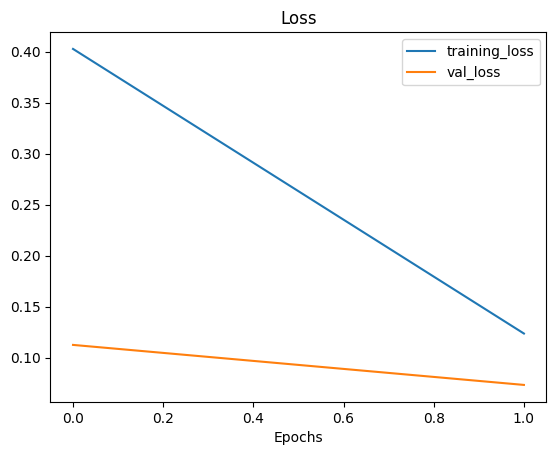

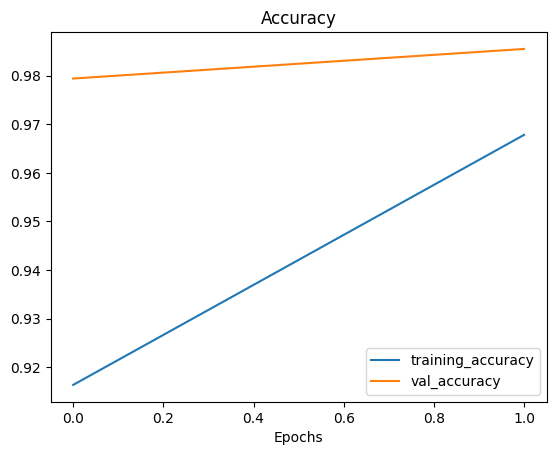

In [23]:
plot_loss_curves(history_0)

In [25]:
# Evaluate on the whole test dataset
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

550/550 [==============================] - 30s 55ms/step - loss: 0.1105 - accuracy: 0.9699


[0.11054600775241852, 0.9698953032493591]

### Saving the feature extraction model

In [26]:
model.save('models/100_percent_model_h5.h5', save_format='h5')

In [27]:
model.save('models/100_percent_model')

INFO:tensorflow:Assets written to: models/100_percent_model\assets


INFO:tensorflow:Assets written to: models/100_percent_model\assets


### Fine Tuning 

In [28]:
# Layers in loaded model
model.layers

In [29]:
# Are these layers trainable?
for layer in model.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x00000202F1613670> True
<keras.engine.sequential.Sequential object at 0x00000200F5411960> True
<keras.engine.functional.Functional object at 0x00000202F19A7940> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x00000200F7F61C90> True
<keras.layers.core.dense.Dense object at 0x00000202F5B5FD30> True


In [32]:
# Layers in our base model(EfficientNetB0) and are they trainable?
for i, layer in enumerate(model.layers[2].layers):
  print(i, layer, layer.name, layer.trainable)

0 <keras.engine.input_layer.InputLayer object at 0x00000202F1613910> input_2 False
1 <keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x00000202F161B490> rescaling_1 False
2 <keras.layers.preprocessing.normalization.Normalization object at 0x00000202BDA0E6B0> normalization_1 False
3 <keras.layers.core.tf_op_layer.TFOpLambda object at 0x00000202F16198D0> tf.math.truediv_1 False
4 <keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x0000020098203F40> stem_conv_pad False
5 <keras.layers.convolutional.conv2d.Conv2D object at 0x00000202F161A530> stem_conv False
6 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x00000202F16A0D60> stem_bn False
7 <keras.layers.core.activation.Activation object at 0x00000202F16A1660> stem_activation False
8 <keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x00000202F16A27A0> block1a_dwconv False
9 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000

In [33]:
# How many trainable variables are there in our base model?
print(len(model.layers[2].trainable_variables))

0


In [34]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainable = True
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

In [35]:
# Check which layers are tunable (trainable)
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_2 False
1 rescaling_1 False
2 normalization_1 False
3 tf.math.truediv_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [36]:
# Recompile (we have to recompile our models every time we make a change)
model.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # When fine tuning you typically wanna lower the learning rate by 10x
                metrics=["accuracy"])

In [37]:
# Now we've unfrozen some of the layers closer to the top, how many trainable variables are there
print(len(model.trainable_variables))

12


In [41]:
initial_epochs = 1

# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 1

# Refit the model (same as model_2 except with more trainable layers)
history_fine_tuned_2 = model.fit(train_data,
                                   epochs=fine_tune_epochs,
                                   validation_data=test_data,
                                   validation_steps=int(0.25*len(test_data)),
                                   initial_epoch=history_0.epoch[-1], # Start training from previous last epoch,
                                   )

Epoch 2/2
2197/2197 [==============================] - 162s 74ms/step - loss: 0.0245 - accuracy: 0.9919 - val_loss: 0.0349 - val_accuracy: 0.9884


In [42]:
# Evaluate on the whole test dataset
fine_tune_results = model.evaluate(test_data)
fine_tune_results

550/550 [==============================] - 31s 55ms/step - loss: 0.0340 - accuracy: 0.9888


[0.03402815759181976, 0.9888458847999573]

### Saving the Fine Tuned model
Most accurate so far

In [44]:
model.save('models/fine_tuned_100_percent_h5.h5', save_format='h5')

In [45]:
model.save('models/fine_tuned_100_percent')

INFO:tensorflow:Assets written to: models/fine_tuned_100_percent\assets


INFO:tensorflow:Assets written to: models/fine_tuned_100_percent\assets


### Testing the model

In [46]:
# Make predictions with our model
preds_probs = model.predict(test_data, verbose=1) # Set verbosity to see how long is left

550/550 [==============================] - 31s 54ms/step


In [47]:
# How many predictions are there?
len(preds_probs)

17572

In [48]:
# What's the shape of our predictions?
preds_probs.shape

(17572, 38)

In [49]:
# Check out class names of out dataset
train_data.class_names

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_

In [50]:
# We get one prediction probability per class (in our case there's 101 prediction probabilities)
print(f"Number of prediction peobabilities for sample 0: {len(preds_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {preds_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {preds_probs[0].argmax()}")

Number of prediction peobabilities for sample 0: 38
What prediction probability sample 0 looks like:
 [9.9999368e-01 2.4174501e-10 1.3189903e-07 5.9210688e-06 2.7327479e-11
 3.3271499e-10 1.2519505e-14 6.4896882e-10 6.4125247e-11 9.6912149e-09
 1.9452592e-11 1.0013519e-09 4.6396431e-10 1.2270465e-08 2.3886415e-08
 4.7394674e-15 3.4019834e-08 1.2556764e-14 5.0128884e-15 2.1827033e-16
 5.7320365e-10 1.6919755e-07 2.2438652e-12 6.8732069e-11 4.8011286e-11
 1.3295654e-08 4.7695686e-10 6.0042937e-10 7.7273986e-12 1.2298504e-13
 1.4887294e-09 1.1681289e-10 3.0785724e-10 2.9480915e-13 4.2302508e-09
 1.8789190e-15 5.8258875e-15 3.9782240e-12]
The class with the highest predicted probability by the model for sample 0: 0


In [51]:
valid_data.class_names[0]

'Apple___Apple_scab'

In [52]:
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [58]:
# To get our test labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())  # Currently test labels look like: [0, 0, 0, 1, .... 0, 0], we want the index value where the "1" occurs
y_labels[:10] # look at the first 10

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [60]:
# How many y_labels are there?
len(y_labels)

17572

In [55]:
# Get a list of class names
class_names = valid_data.class_names
class_names[:10]

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight']

In [61]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# We need to make some changes to our make_confusion_matrix function to ensure the x-labels print vertically
# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Changed (plot x-labels vertically) ###
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix_100_percent_data.png")

In [62]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100,100),
                      text_size=20,
                      savefig=True)

In [63]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       504
           1       1.00      1.00      1.00       497
           2       1.00      0.99      0.99       440
           3       0.97      1.00      0.98       502
           4       1.00      1.00      1.00       454
           5       1.00      1.00      1.00       421
           6       1.00      1.00      1.00       456
           7       0.97      0.93      0.95       410
           8       1.00      1.00      1.00       477
           9       0.95      0.98      0.96       477
          10       1.00      1.00      1.00       465
          11       0.99      1.00      0.99       472
          12       1.00      0.99      0.99       480
          13       1.00      1.00      1.00       430
          14       1.00      1.00      1.00       423
          15       1.00      1.00      1.00       503
          16       0.99      1.00      0.99       459
          17       1.00    

In [64]:
# Get a dictionary of classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.9939024390243902,
  'recall': 0.9702380952380952,
  'f1-score': 0.9819277108433735,
  'support': 504.0},
 '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 497.0},
 '2': {'precision': 0.9977064220183486,
  'recall': 0.9886363636363636,
  'f1-score': 0.9931506849315069,
  'support': 440.0},
 '3': {'precision': 0.9691119691119691,
  'recall': 1.0,
  'f1-score': 0.984313725490196,
  'support': 502.0},
 '4': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 454.0},
 '5': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 421.0},
 '6': {'precision': 1.0,
  'recall': 0.9978070175438597,
  'f1-score': 0.9989023051591658,
  'support': 456.0},
 '7': {'precision': 0.9745547073791349,
  'recall': 0.9341463414634147,
  'f1-score': 0.9539227895392279,
  'support': 410.0},
 '8': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 477.0},
 '9': {'precision': 0.947261663286004,
  'recall': 0.9790356394129979,
  'f1-score': 0.96288

In [65]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report dictionary items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy
    break
  else:
    # Add class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]


class_f1_scores

{'Apple___Apple_scab': 0.9819277108433735,
 'Apple___Black_rot': 1.0,
 'Apple___Cedar_apple_rust': 0.9931506849315069,
 'Apple___healthy': 0.984313725490196,
 'Blueberry___healthy': 1.0,
 'Cherry_(including_sour)___Powdery_mildew': 1.0,
 'Cherry_(including_sour)___healthy': 0.9989023051591658,
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 0.9539227895392279,
 'Corn_(maize)___Common_rust_': 1.0,
 'Corn_(maize)___Northern_Leaf_Blight': 0.9628865979381444,
 'Corn_(maize)___healthy': 0.9989235737351991,
 'Grape___Black_rot': 0.991578947368421,
 'Grape___Esca_(Black_Measles)': 0.9916142557651992,
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 1.0,
 'Grape___healthy': 1.0,
 'Orange___Haunglongbing_(Citrus_greening)': 1.0,
 'Peach___Bacterial_spot': 0.9934782608695654,
 'Peach___healthy': 0.9942062572421785,
 'Pepper,_bell___Bacterial_spot': 0.9927159209157128,
 'Pepper,_bell___healthy': 0.9899193548387096,
 'Potato___Early_blight': 0.9969167523124358,
 'Potato___Late_blight': 0.9908

In [66]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)

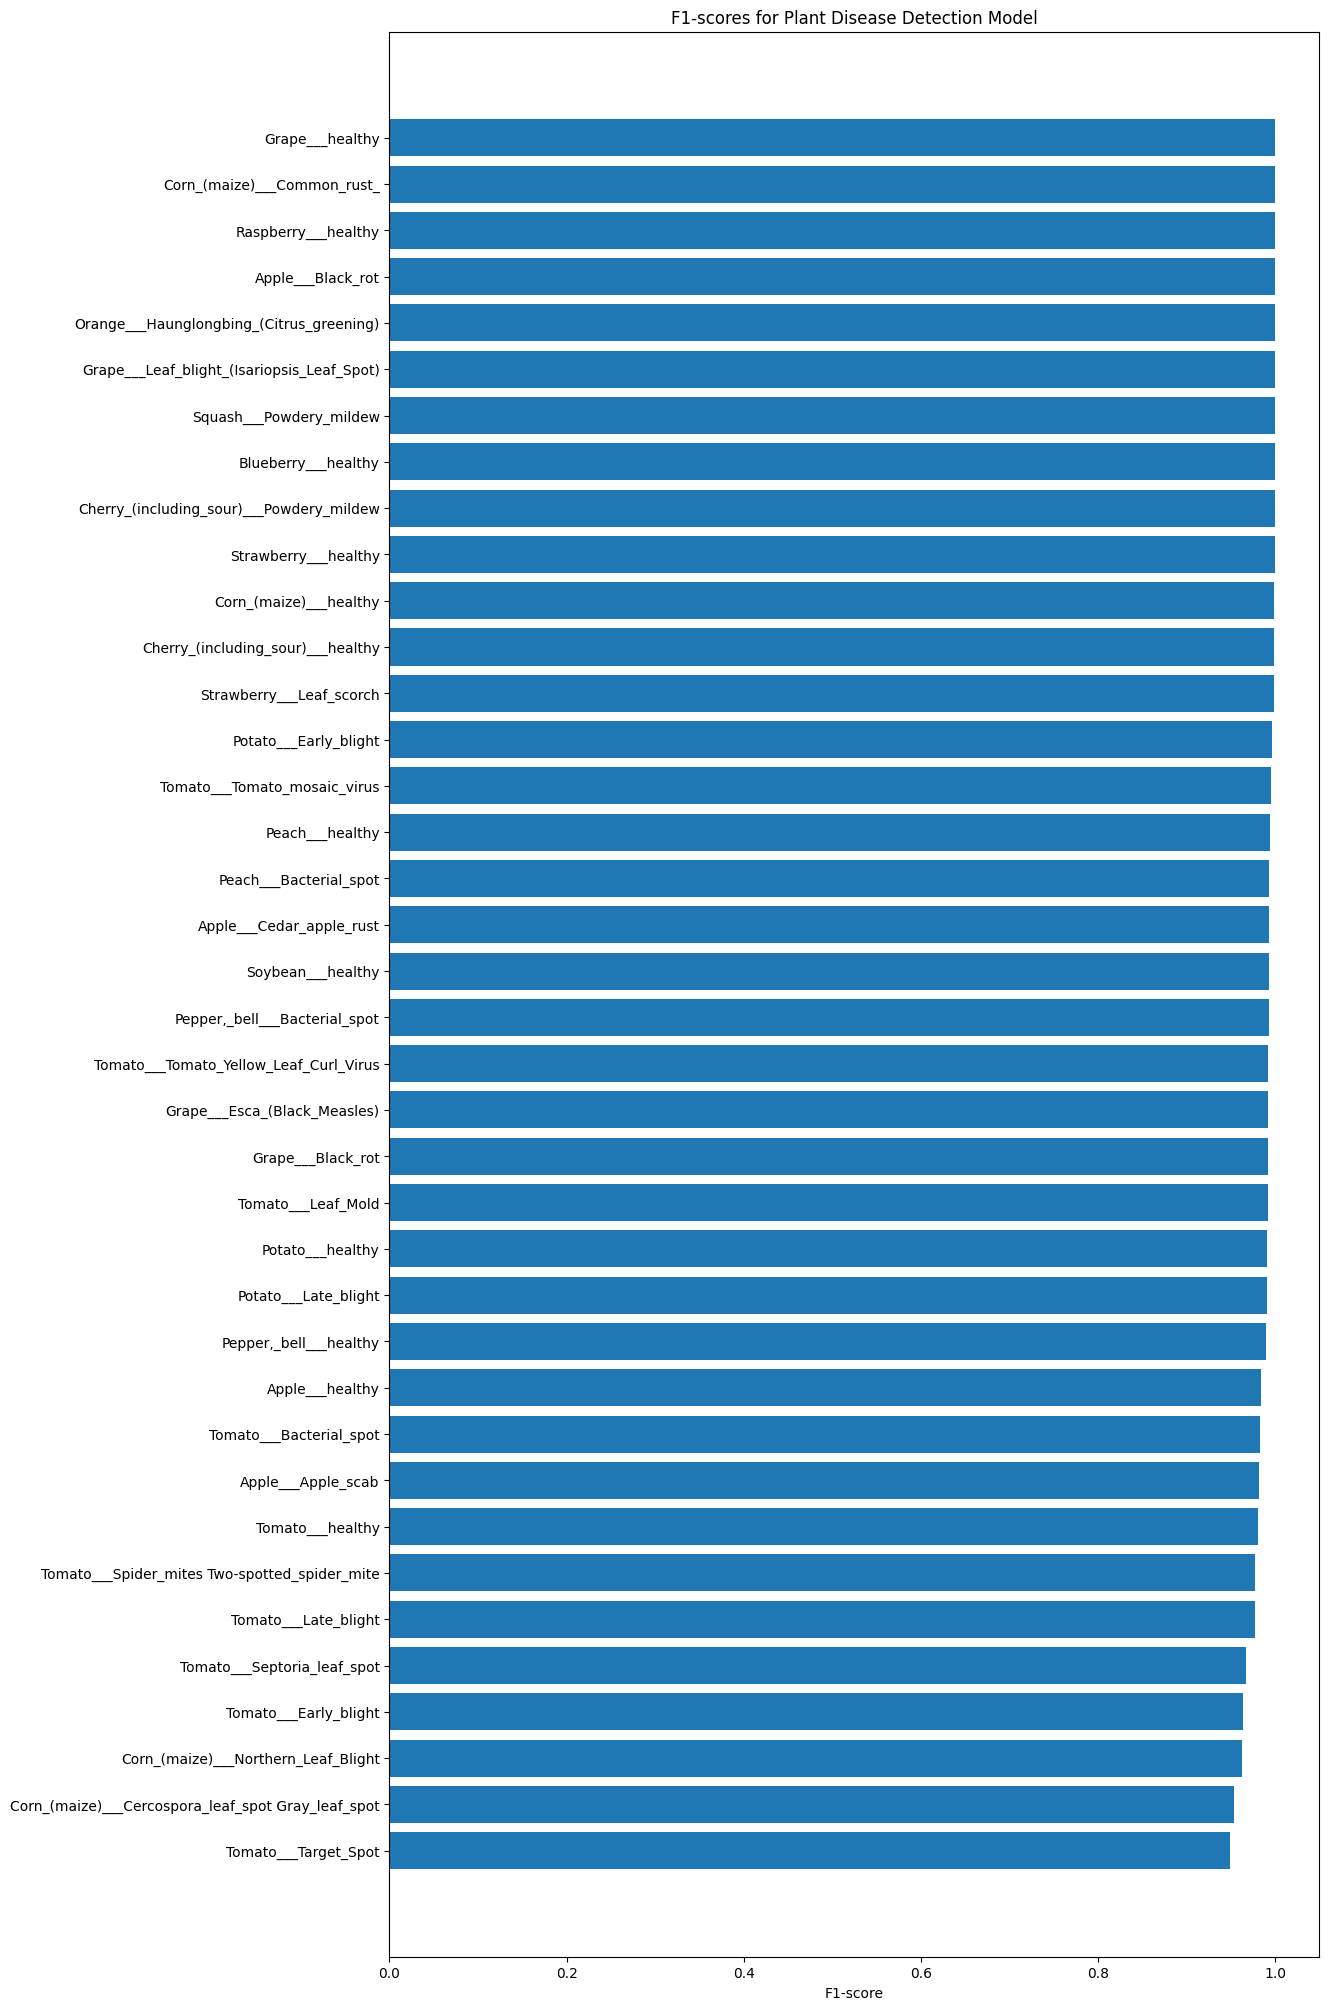

In [67]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)  # get f1-score values

ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1-scores for Plant Disease Detection Model")
ax.invert_yaxis()

### Testing on custom data

In [69]:
# Create a function to load and prepare images
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  specified shape (img_shape, img_shape, color_channels=3).

  Args:
    filename (str): path to target image
    img_shape (int): height/width dimension of target image size
    scale (bool): scale pixel values from 0-255 to 0-1 or not.

  Returns:
    Image tensor of shape (img_shape, img_shape, 3)
  """

  # Read in the image
  img = tf.io.read_file(filename)

  # Decode image into tensor
  img = tf.io.decode_image(img, channels=3)

  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])

  # Scale? yes/no
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.

  else:
    return img # don't need to rescale for EfficicentNet models in Tensorflow

In [70]:
import os
# Get the custom food images file paths
custom_food_images = ["custom_food_images/"+img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/20170815a-max-pixel.jpg',
 'custom_food_images/800wm.jpeg',
 'custom_food_images/apple_cedar_rust.jpg',
 'custom_food_images/apple_healthy.JPG',
 'custom_food_images/corn-leaves.jpg',
 'custom_food_images/corn.jpg',
 'custom_food_images/images (1).jpeg',
 'custom_food_images/images.jpeg',
 'custom_food_images/Screenshot 2024-04-07 014900.png',
 'custom_food_images/Screenshot 2024-04-07 015101.png',
 'custom_food_images/strawberry_common_leaf_spot.jpg',
 'custom_food_images/The-three-Sample-leaves-of-potato-are-a-leaf-affected-by-Light-Blight-b-leaf.png']

1/1 [==============================] - 0s 29ms/step


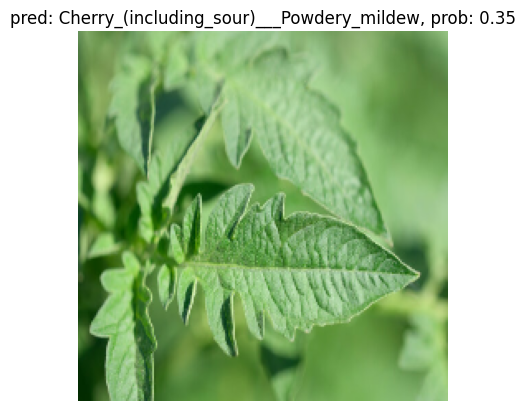

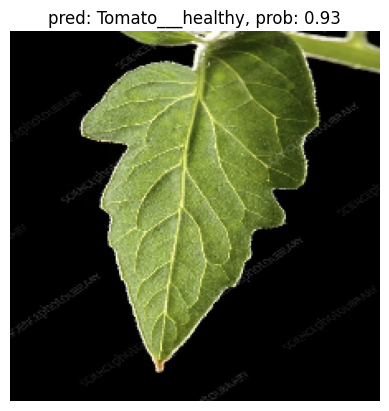

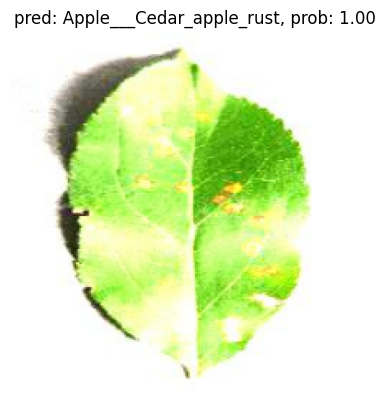

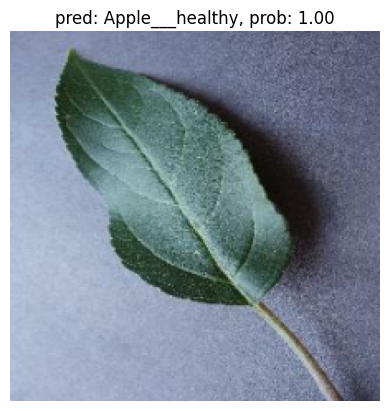

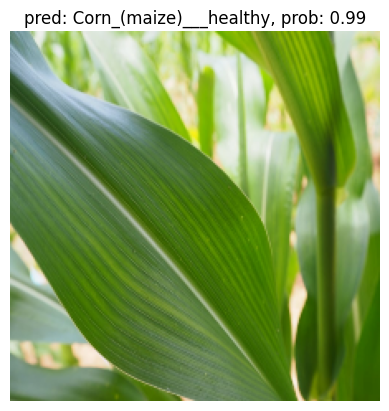

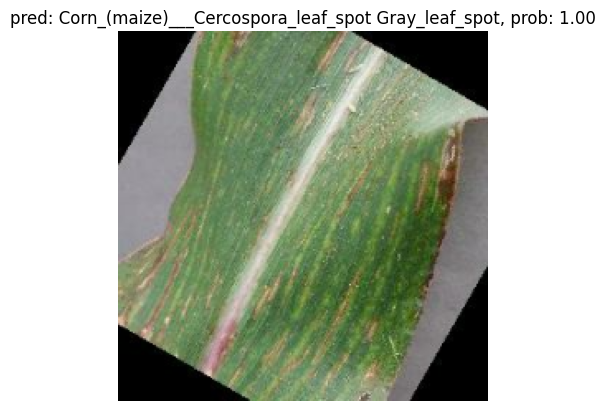

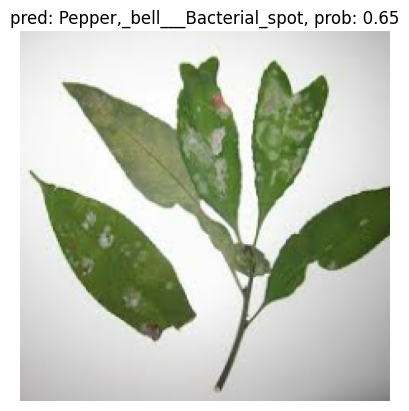

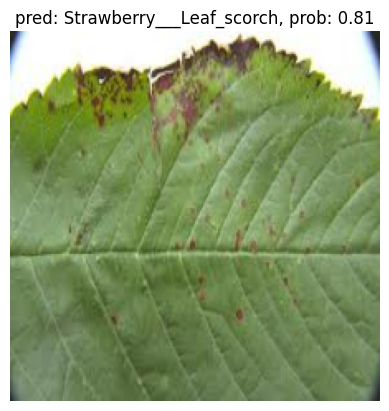

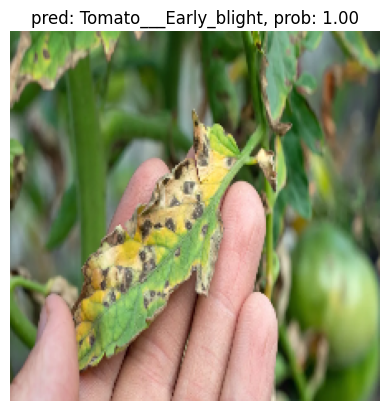

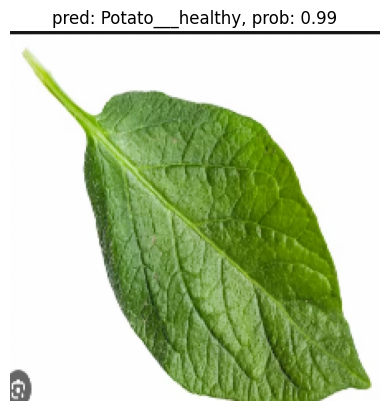

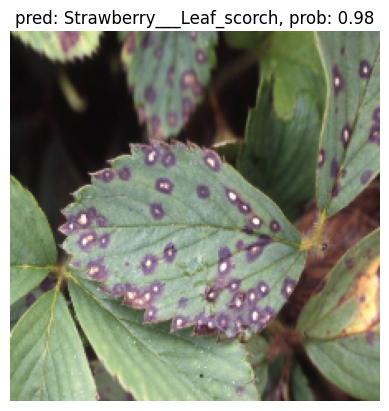

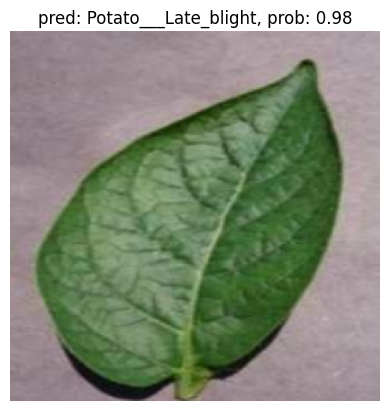

In [72]:
# Make predictions on and plot custom food images
for img in custom_food_images:
  img  = load_and_prep_image(img, scale=False)  # don't need to scale for EfficientNetb0
  pred_prob = model.predict(tf.expand_dims(img, axis=0))   # make prediction on image with shape [1, 224, 224, 3] (same shape on which our model waas trained on)
  pred_class = class_names[pred_prob.argmax()]  # get the index with the highest prediction probability

  # Plot the appropriate information
  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)